# Analysis of Mobile Games

### Quinn Morris

## Introduction/Background

Mobile gaming experiences can range from a casual, non-commital, completely free experience to that of an potential monetary sinkhole that may demand you to spend hours of your time.

I, personally, play several mobile games and do enjoy jumping from game to game just to see what each one is like. But sometimes, I get curious to see the app store statistics behind these titles and wonder how they rank in terms of other games as well. 


### Inspiration
The main inspiration for this curiosity was this article (https://www.gamespot.com/articles/an-anime-inspired-game-surpassed-fortnite-as-twitt/1100-6464600/) from Gamespot. In it, it states that Fortnite, the mobile version of the infamous battle royale game that was heavily popularized at the time, was actually talked about **less** than the mobile game Fate/Grand Order, which I was an avid player of at the time. While I'm not too completely sure about how much revenue and how big of a fanbase each game had at the time (this was from 2018), I have been curious to see how some of the Mobile Games I play stack up to other games on the market.

## Purpose

This project aims to analyze 2019 app data from the iTunes and Google Play stores, analyzing and combining both datasets and viewing any sorts of trends that can be derived from them, in a way, establishing a tierlist of sorts between all of these games. We will also do a brief look into revenue streams for certain apps and look at the relationship between ranking, reviews and revenue. 

## Datasets

The iTunes mobile game dataset can be found here: https://www.kaggle.com/tristan581/17k-apple-app-store-strategy-games

The Google Play Store mobile game dataset can be found here:
https://www.kaggle.com/lava18/google-play-store-apps/home?select=googleplaystore.csv

This project will also scrape data from https://thinkgaming.com/app-sales-data which covers data pertaining to iTunes mobile game sales (not android). Unfortunately, most data pertaining to mobile game sales is locked behind paywalls from sites such as "Think Gaming" and "Sensor Tower" which provide a wide variety of metrics mainly intended for corporate usage.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re

### Preface: Using the iTunes API to gather current data

While I use this pre-formatted, established iTunes app dataset here, there also is a way to access iTunes app data using search API's that apple provides. The API itself is limited to around 20 queries per minute and is also geared more towards music. The only reason I share this with you is that it is possible to scrape all of the current data for ALL games using the iTunes sitemap and iTunes API. However for the purposes of this tutorial, I will leave the creation and curation of a more "current" dataset up to you.

The documentation is here: https://affiliate.itunes.apple.com/resources/documentation/itunes-store-web-service-search-api/

The iTunes sitemap (for games) is here:
https://apps.apple.com/us/genre/ios-games/id6014

I also provide a sample query below:

In [2]:
# Sample query of the itunes API for the game Fate/Grand Order which is one of the games I play
query = requests.get("https://itunes.apple.com/search?producerTerm=Aniplex+Inc.&term=Fate/Grand+Order&entity=software")
print(f"Status of request: {query}")

# This to iterate through the results, it's just a simple for loop
'''
for item in query.json()["results"]:
    print(item["trackName"] + ", " + str(item["description"]))
'''

#Just gonna grab the first response for brevity
item = query.json()["results"][0]
print(item["trackName"] + ", " + str(item["description"]))

Status of request: <Response [200]>
Fate/Grand Order (English), A new mobile "Fate RPG," presented by TYPE-MOON!
With an impressive main scenario and multiple character quests, 
the game features millions of words of original story!
Packed with content that both fans of the Fate franchise and newcomers will be able to enjoy.

Summary

2017 A.D. 
Chaldea, an organization tasked with observing Earth's future, has confirmed that human history will be eliminated at 2019. 
Without warning, the promised future of 2017 disappeared.
Why? How? Who? By what means?
AD. 2004. A certain provincial town in Japan.
For the first time ever, a region that could not be observed appeared.
Assuming that this was the cause of humanity’s extinction, Chaldea carried out its sixth experiment - time travel into the past.
A forbidden ceremony where they would convert humans into Spiritrons and send them back in time. By intervening in events, they would locate, identify, and destroy the space-time Singularities.

## Data Curation/Parsing

### Part 1: iTunes

In [3]:
# We can read in the itunes dataset using a simple pandas read_csv() command
itunes_df = pd.read_csv("./itunes_dataset/appstore_games.csv")
itunes_df.head(5)

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


For our purposes, I think it's safe to just delete the columns for ***URL, subtitle, the icon URL and age rating*** from this dataframe for the time being

In [4]:
try:
    del itunes_df["URL"]
    del itunes_df["Icon URL"]
    del itunes_df["Age Rating"]
    del itunes_df["Subtitle"]
except:
    print("Rows already deleted")

I will also rename the columns and convert some of them to a more manageable and readable format

In [5]:
# Rename the columns
renamed_cols = [item.lower() for item in itunes_df.columns.tolist()]
itunes_df.columns = renamed_cols

# Convert the release data and current version release date columns into datetime objects
itunes_df["current version release date"] = itunes_df["current version release date"].apply(lambda item: pd.to_datetime(item))
itunes_df["original release date"] = itunes_df["original release date"].apply(lambda item: pd.to_datetime(item))

# Convert the size (in bytes) to megabytes
itunes_df["size"] = itunes_df["size"].apply(lambda item: item/1000000)

# Break up the languages, and genres columns into lists
itunes_df["languages"] = itunes_df["languages"].apply(lambda countries: str(countries).split(","))
itunes_df["genres"] = itunes_df["genres"].apply(lambda countries: str(countries).split(","))

# Rename some columns for brevity
itunes_df.rename(columns={"size": "size (MB)"}, inplace=True)
itunes_df.head(5)

,id,name,average user rating,user rating count,price,in-app purchases,description,developer,languages,size (MB),primary genre,genres,original release date,current version release date
0,284921427,Sudoku,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,"[DA, NL, EN, FI, FR, DE, IT, JA, KO, ...",15.853568,Games,"[Games, Strategy, Puzzle]",2008-11-07,2017-05-30
1,284926400,Reversi,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,[EN],12.328960,Games,"[Games, Strategy, Board]",2008-11-07,2018-05-17
2,284946595,Morocco,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,[EN],0.674816,Games,"[Games, Board, Strategy]",2008-11-07,2017-05-09
3,285755462,Sudoku (Free),3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,"[DA, NL, EN, FI, FR, DE, IT, JA, KO, ...",21.552128,Games,"[Games, Strategy, Puzzle]",2008-07-23,2017-05-30
4,285831220,Senet Deluxe,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,"[DA, NL, EN, FR, DE, EL, IT, JA, KO, ...",34.689024,Games,"[Games, Strategy, Board, Education]",2008-07-18,2018-07-22


### Part 2: Google Play

In [6]:
# We can read in the google play CSV using the read_csv pandas function too 
google_play_df = pd.read_csv("./google_play_dataset/googleplaystore.csv")
google_play_df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Looking at this dataset from a glance, I think it's safe to say that we can remove the columns for ***current version, android version, and content rating***

In [7]:
try:
    del google_play_df["Current Ver"]
    del google_play_df["Android Ver"]
    del google_play_df["Content Rating"]
except:
    print("Rows already deleted")

From here, I'm gonna lowercase the category column and remove underscores, change size to a proper float (converting bytes properly), remove any extra bits from installs (so it's just a flat install number), reformat Genres to be a string list, convert price into a float column and convert Last Updated to a proper datetime

In [8]:
# Helper functions

# This is just to extract the digits from a number that is formatted with commas. 
# We eliminate commas using the split function to properly extract the proper numerical amount.
def get_numeric(item):
    value = str(item).lower()
    value = value.replace(",", "")
    return re.search("\d+", value).group(0)

# Take the Size entries and convert them to a readable amount in megabytes
def convert_to_megabytes(item):
    value = str(item).upper()
    
    # Any value that involes "varies with device" is an nan
    if value == "VARIES WITH DEVICE":
        return np.nan
    
    # We search for any numerical value followed by an M or a K (mega or kilobytes)
    size_regex = r"^(\d+(?:\.\d+)?)([MK])$"
    result = re.search(size_regex, value)
    #print(result[1] + " " + result[2])
    if result.group(2) == "K":
        # We divide kilobyte float values by 1000 to get megabytes
        return float(result.group(1))/1000
    else:
        return float(result.group(1))

In [9]:
# Make the column names lowercase
renamed_cols = [item.lower() for item in google_play_df.columns.tolist()]
google_play_df.columns = renamed_cols

# Filter out the non game categories
google_play_df = google_play_df[google_play_df['category'] == "GAME"]

# Convert the last updated column to a proper datetime
google_play_df["last updated"] = google_play_df["last updated"].apply(lambda item: pd.to_datetime(item))

# Convert the size (in bytes) to megabytes
google_play_df["size"] = google_play_df["size"].apply(lambda item: convert_to_megabytes(item))

# Break up the genres of each game into lists, the genres are semicolon separated in their own respective entry
google_play_df["genres"] = google_play_df["genres"].apply(lambda countries: str(countries).split(";"))

    
# Remove the plus from the installs column and extract the actual number of installs 
google_play_df["installs"] = google_play_df["installs"].apply(lambda item: int(get_numeric(item)))

# Rename some columns for brevity
google_play_df.rename(columns={"size": "size (MB)"}, inplace=True)

In [10]:
# Display the data frame
google_play_df.head(10)

,app,category,rating,reviews,size (MB),installs,type,price,genres,last updated
1653,ROBLOX,GAME,4.5,4447388,67.0,100000000,Free,0,"[Adventure, Action & Adventure]",2018-07-31
1654,Subway Surfers,GAME,4.5,27722264,76.0,1000000000,Free,0,[Arcade],2018-07-12
1655,Candy Crush Saga,GAME,4.4,22426677,74.0,500000000,Free,0,[Casual],2018-07-05
1656,Solitaire,GAME,4.7,254258,23.0,10000000,Free,0,[Card],2018-08-01
1657,Bubble Shooter,GAME,4.5,148897,46.0,10000000,Free,0,[Casual],2018-07-17
1658,Hello Kitty Nail Salon,GAME,4.2,369203,24.0,50000000,Free,0,"[Casual, Pretend Play]",2018-04-17
1659,slither.io,GAME,4.4,5234162,NaN,100000000,Free,0,[Action],2017-11-14
1660,Clash Royale,GAME,4.6,23133508,97.0,100000000,Free,0,[Strategy],2018-06-27
1661,Temple Run 2,GAME,4.3,8118609,62.0,500000000,Free,0,[Action],2018-07-05
1662,Pou,GAME,4.3,10485308,24.0,500000000,Free,0,[Casual],2018-05-25


### Part 3: iTunes Mobile Game Revenues

For this part of the project, we are actively scraping data from separate pages on a website and actively consolidating them using a for loop. This same process can be done with the iTunes store data although there will be many more pages to parse as a result.

For this example/demonstration, I will be extracting data from four pages on the thinkgaming website pertaining to the app sales and consolidating them into one dataset. This code grabs the most recent results from the website.

In [11]:
# We can't iterate over the four pages so we have to make a separate query for each of them. 
pages = ["https://thinkgaming.com/app-sales-data/", "https://thinkgaming.com/app-sales-data/?page=2", 
         "https://thinkgaming.com/app-sales-data/?page=3", "https://thinkgaming.com/app-sales-data/?page=4"]

mobile_game_sales_df = None

# We will iterate through each page to gather the queries
for page in pages:
    query = requests.get(page)
    soup = BeautifulSoup(query.text, "html.parser")
    table = soup.find("table")
    df = pd.read_html(str(table))[0]
    
    # We assign the mobile game sales dataframe to the first dataframe to assume the same number of columns
    # The else statement allows us to append the other data to it on the other pages (all the data has the same number of columns)
    if mobile_game_sales_df is None:
        mobile_game_sales_df = df
    else:
        mobile_game_sales_df = mobile_game_sales_df.append(df, ignore_index=True)
        
mobile_game_sales_df.head(10)

,#,Free,Paid,Game,Publisher,Price,"Revenue?Gross Revenue for the day, including in-app purchases and purchase price of the game. Subscribers can access ad revenue estimates.",New Installs?Number of times this game was installed during the day. Excludes re-installs.
0,1,22,-,Fortnite,Epic Games,Free,"$2,766,224",18936
1,2,114,-,Clash of Clans,Supercell,Free,"$2,417,331",20744
2,3,13,-,Roblox,Roblox Corporation,Free,"$2,417,331",20754
3,4,79,-,Candy Crush Saga,King,Free,"$1,812,241",17008
4,5,30,-,Coin Master,Moon Active,Free,"$979,942",19116
5,6,77,-,Gardenscapes,Playrix,Free,"$694,220",16726
6,7,56,-,Pokémon GO,"Niantic, Inc.",Free,"$414,535",17617
7,8,38,-,Homescapes,Playrix,Free,"$357,151",15837
8,9,-,-,Toon Blast,Peak Games,Free,"$284,305",19905
9,10,83,-,PUBG MOBILE - Mad Miramar,Tencent Mobile International Limited,Free,"$237,195",20812


From here, we can get rid of the ***Free and Paid*** Columns since those pertain to rankings among free and paid games and we need to rename the columns for rank (i.e. "#"), revenue, and new installs

In [12]:
try:
    del mobile_game_sales_df["Free"]
    del mobile_game_sales_df["Paid"]
except:
    print("Rows already deleted")

In [13]:
# Rename the # column, the Revenue column and the New Installs column 

# Lowercase first
mobile_game_sales_df.rename(columns=str.lower, inplace=True)

# Rename columns
mobile_game_sales_df.rename(columns={"#": "rank", mobile_game_sales_df.columns[4]: "revenue", mobile_game_sales_df.columns[5]: "new installs"}, inplace=True)

# Convert the revenue column into a proper integer value
mobile_game_sales_df["revenue"] = mobile_game_sales_df["revenue"].apply(lambda item: float(get_numeric(item)))

mobile_game_sales_df.head(5)

,rank,game,publisher,price,revenue,new installs
0,1,Fortnite,Epic Games,Free,2766224.0,18936
1,2,Clash of Clans,Supercell,Free,2417331.0,20744
2,3,Roblox,Roblox Corporation,Free,2417331.0,20754
3,4,Candy Crush Saga,King,Free,1812241.0,17008
4,5,Coin Master,Moon Active,Free,979942.0,19116


# Exploratory Analysis

In [14]:
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.linear_model import LinearRegression
from scipy import stats

## Combine Datasets

In [15]:
itunes_df.shape

(17007, 14)

In [16]:
google_play_df.shape

(1144, 10)

In [17]:
mobile_game_sales_df.head(5)

,rank,game,publisher,price,revenue,new installs
0,1,Fortnite,Epic Games,Free,2766224.0,18936
1,2,Clash of Clans,Supercell,Free,2417331.0,20744
2,3,Roblox,Roblox Corporation,Free,2417331.0,20754
3,4,Candy Crush Saga,King,Free,1812241.0,17008
4,5,Coin Master,Moon Active,Free,979942.0,19116


In [18]:
# Combine the itunes dataframe and google dataframe into one column.
condensed_itunes_df = pd.DataFrame(itunes_df, columns=["name", "average user rating", "user rating count"])
condensed_google_df = pd.DataFrame(google_play_df, columns=["app", "rating", "reviews"])

# Rename the columns so its easier to merge
condensed_google_df.rename(columns={"app":"name", "rating":"average user rating", "reviews": "user rating count"}, inplace=True)

# Merge the dataframes
condensed_df = condensed_itunes_df.append(condensed_google_df, ignore_index=True)

# Convert user rating count to an integer...
condensed_df["user rating count"] = condensed_df["user rating count"].apply(lambda item: float(item))

In [19]:
condensed_df

,name,average user rating,user rating count
0,Sudoku,4.0,3553.0
1,Reversi,3.5,284.0
2,Morocco,3.0,8376.0
3,Sudoku (Free),3.5,190394.0
4,Senet Deluxe,3.5,28.0
...,...,...,...
18146,Winter Wonderland,4.0,1287.0
18147,Soccer Clubs Logo Quiz,4.2,21661.0
18148,Sid Story,4.4,28510.0
18149,Fatal Raid - No.1 Mobile FPS,4.3,56496.0


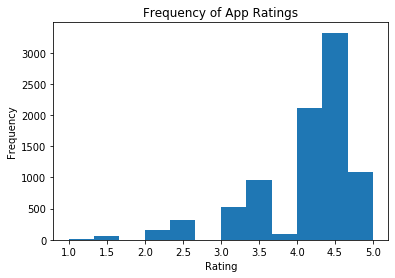

In [20]:
# Plot histogram of ratings 
condensed_df["average user rating"].plot.hist(bins=12, alpha=1)
plt.xlabel('Rating')
plt.title("Frequency of App Ratings")
plt.show()

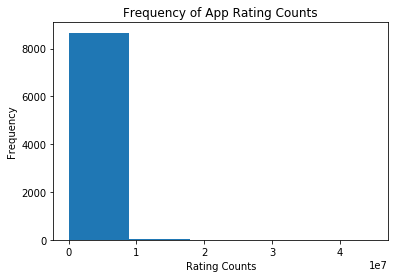

In [21]:
# Plot histogram of user rating counts
condensed_df["user rating count"].plot.hist(bins=5, alpha=1)
plt.xlabel('Rating Counts')
plt.title("Frequency of App Rating Counts")
plt.show()

Between both of these histograms, most ratings for gaming apps are generally skewed left (which is good in the game developers case) and with the app rating counts (i.e. number of people who rate a given app total), the histogram is skewed right which doesn't sound too good on the surface, but when taking into account the scale of it all, the number of reviews are well within the range from hundreds to millions of people. 

## Combine the Scraped Revenue Data with the iTunes Dataset

The only reason why I am combining the scraped revenue data with the iTunes dataset is because the revenue data pertains only to itunes apps. However, one major problem with this dataset at the time of writing this is that the user ratings and ratings counts are for the games from 2019. The revenue and number of new installs are current.

Grabbing historical revenue data for itunes apps, especially gaming apps, is incredibly difficult as a majority of that content is behind paywalls, so for the sake of this tutorial, I will just be walking through a basic analysis of this merged dataset.

In [22]:
condensed_sales_df = pd.DataFrame(mobile_game_sales_df, columns=["game", "revenue", "new installs"])
condensed_sales_df.rename(columns={"game": "name"}, inplace=True)

merged_df = pd.merge(condensed_sales_df, condensed_itunes_df, on='name')

In [23]:
merged_df

,name,revenue,new installs,average user rating,user rating count
0,Clash of Clans,2417331.0,20744,4.5,3032734.0
1,Rise of Kingdoms,144105.0,20785,4.5,30480.0
2,Empires & Puzzles: RPG Quest,128964.0,17777,4.5,46733.0
3,Mafia City: War of Underworld,99817.0,21421,5.0,88542.0
4,King of Avalon: Dragon Warfare,95154.0,20091,4.0,13151.0
5,Summoners War,87909.0,21028,4.5,153052.0
6,Clash Royale,77258.0,15581,4.5,1277095.0
7,Last Shelter: Survival,77103.0,15455,4.0,10281.0
8,West Game,75190.0,20285,4.5,3634.0
9,Age of Z,70390.0,14440,4.5,3553.0


Looking at the merged data, there unfortunately isn't enough to merit splitting into training, validation and testing data for unsupervised machine learning models. 

However, we can still extrapolate and do multiple linear regression on this data to determine how certain statistics such as number of installs, user rating or user count affect the total revenue earned for the game.

In [24]:
# These are the parameters we're interested in
X = merged_df[['new installs', 'average user rating', 'user rating count']]
Y = merged_df['revenue']

# Fit the regression model with these terms
regr = LinearRegression()
regr.fit(X, Y)

# Print to verify
# print('Intercept: \n', inter_regr.intercept_)
# print('Coefficients: \n', inter_regr.coef_)

# Shorten the names for retrieving intercept and coefficient
intercept = regr.intercept_
coef = regr.coef_

# Print out the formula
print("y = {}x_1 + {}x_2 + {}x_3 + {}".format(coef[0], coef[1], coef[2], intercept))
print("x_1 is new installs\nx_2 is average user rating\nx_3 is user rating count")

y = 17.47632555745708x_1 + -46233.70287338268x_2 + 0.6765932738256535x_3 + -115996.46166684758
x_1 is new installs
x_2 is average user rating
x_3 is user rating count


Looking at these coefficients, it seems that average user ratings is statistically significant towards the effectiveness of the model, followed by the number of new installs.

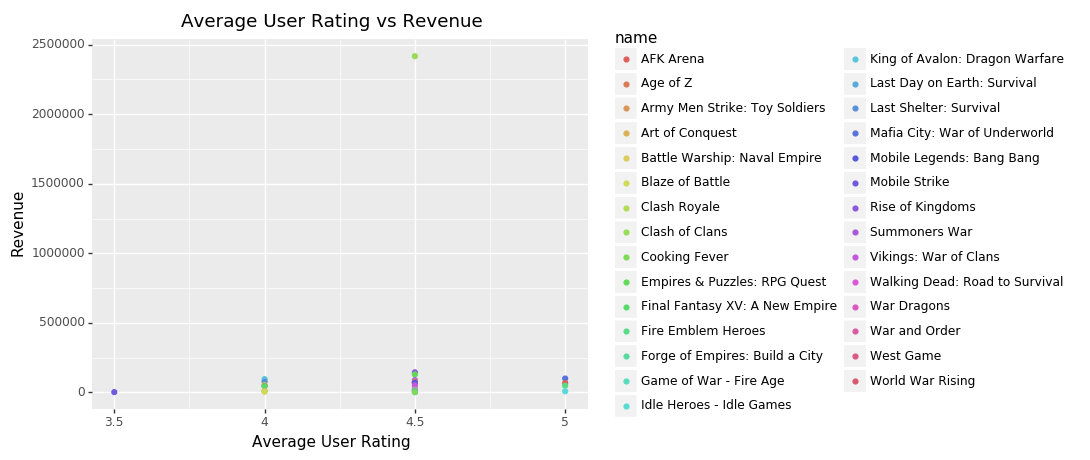

<ggplot: (-9223371922070024376)>

In [25]:
# We can also analyze scatterplots for how user ratings affect revenue
(ggplot(merged_df, aes(x='average user rating', y='revenue', color = 'name')) 
    + geom_point() 
    + labs(title="Average User Rating vs Revenue",
        x = "Average User Rating",
        y = "Revenue")
)

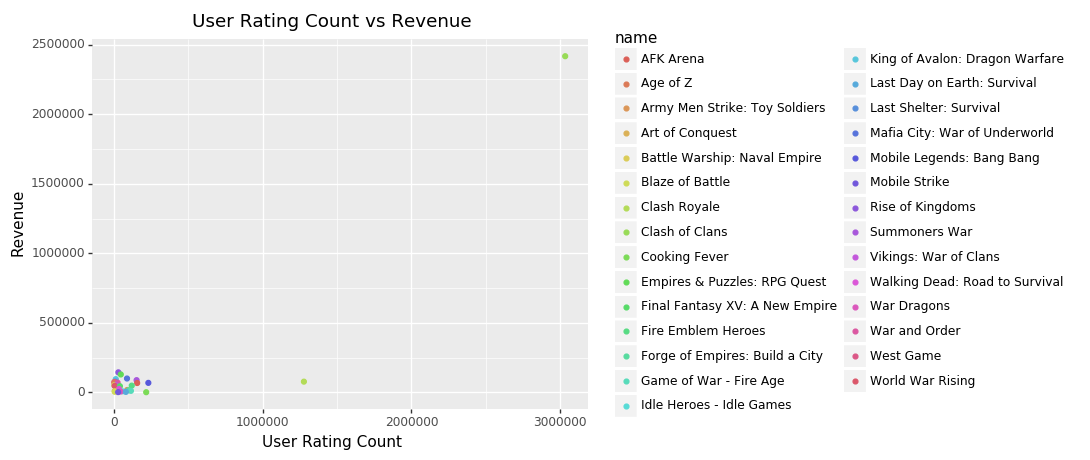

<ggplot: (-9223371922069823908)>

In [26]:
# Same thing for rating counts...
(ggplot(merged_df, aes(x='user rating count', y='revenue', color = 'name')) 
    + geom_point() 
    + labs(title="User Rating Count vs Revenue",
        x = "User Rating Count",
        y = "Revenue")
)

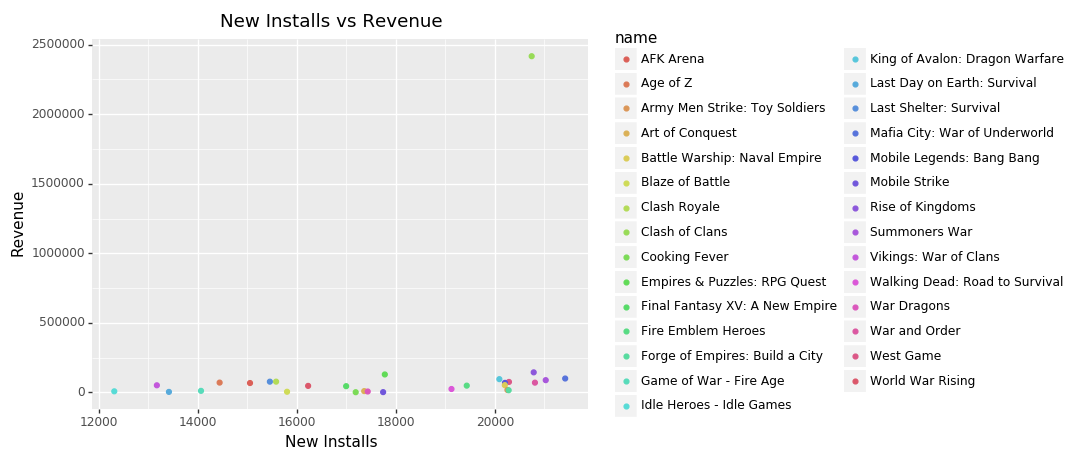

<ggplot: (-9223371922069869808)>

In [27]:
# ... and for number of installs
(ggplot(merged_df, aes(x='new installs', y='revenue', color = 'name')) 
    + geom_point() 
    + labs(title="New Installs vs Revenue",
        x = "New Installs",
        y = "Revenue")
)

Looking at the data plots here, it seems that Clash of Clans is the biggest outlier in these datasets.